ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11328749218780515593, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6043238465196575500
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12454031721211903382
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3588327808493816474
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

オープンソースのCNN darkentをcloneしてビルド。

In [3]:
%%bash
git clone https://github.com/pjreddie/darknet
cd darknet
make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

Cloning into 'darknet'...


YOLOv3のweightをダウンロード。

In [4]:
%%bash
cd ./darknet
wget https://pjreddie.com/media/files/yolov3.weights

--2020-11-12 09:45:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

     0K .......... .......... .......... .......... ..........  0%  224K 18m3s
    50K .......... .......... .......... .......... ..........  0%  248K 17m10s
   100K .......... .......... .......... .......... ..........  0%  357K 15m12s
   150K .......... .......... .......... .......... ..........  0%  353K 14m16s
   200K .......... .......... .......... .......... ..........  0%  319K 13m56s
   250K .......... .......... .......... .......... ..........  0%  290K 13m55s
   300K .......... .......... .......... .......... ..........  0%  299K 13m52s
   350K .......... .......... .......... .......... ..........  0%  164K 15m11s
   400K .......... .......... 

サンプルで入っている画像（darknet/data/giraffe.jpg）に物体検知をかける。

In [5]:
%%bash
cd ./darknet/
./darknet detect cfg/yolov3.cfg yolov3.weights data/giraffe.jpg

data/giraffe.jpg: Predicted in 19.506627 seconds.
giraffe: 98%
zebra: 98%


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

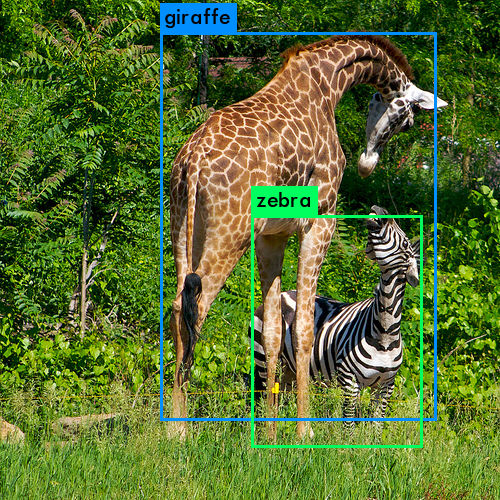

In [6]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('darknet/predictions.jpg'))

サンプルで入っている別の画像（darknet/data/person.jpg）も試してみる。

In [7]:
%%bash
cd ./darknet/
./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

data/person.jpg: Predicted in 19.202171 seconds.
horse: 100%
dog: 99%
person: 100%


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

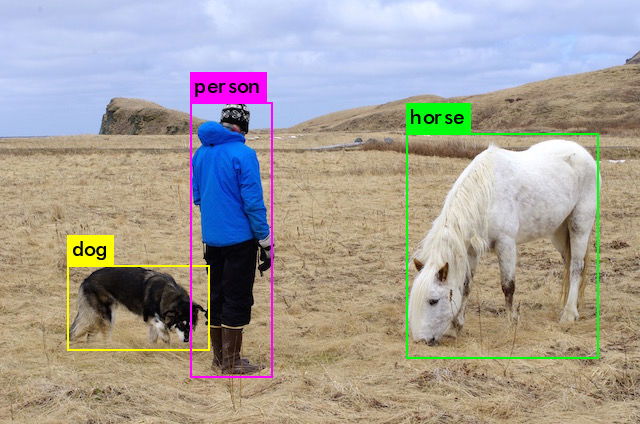

In [8]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('darknet/predictions.jpg'))

手持ちの画像をGoogle Driveにアップロードする。  drive/My Drive/sample.jpg

Google Driveアップロードした画像を darknet にコピーする。

In [9]:
%%bash
cp drive/My\ Drive/sample.jpg darknet/

アップロードした画像（darknet/sample.jpg）に物体検知をかける。

In [10]:
%%bash
cd ./darknet/
./darknet detect cfg/yolov3.cfg yolov3.weights sample.jpg

sample.jpg: Predicted in 19.686177 seconds.
traffic light: 94%
traffic light: 81%
traffic light: 57%
traffic light: 57%
motorbike: 65%
car: 100%
car: 96%
car: 87%
car: 73%
car: 58%
person: 99%
person: 98%
person: 98%
person: 98%
person: 95%
person: 95%
person: 95%
person: 95%
person: 93%
person: 92%
person: 88%
person: 79%
person: 77%
person: 62%


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

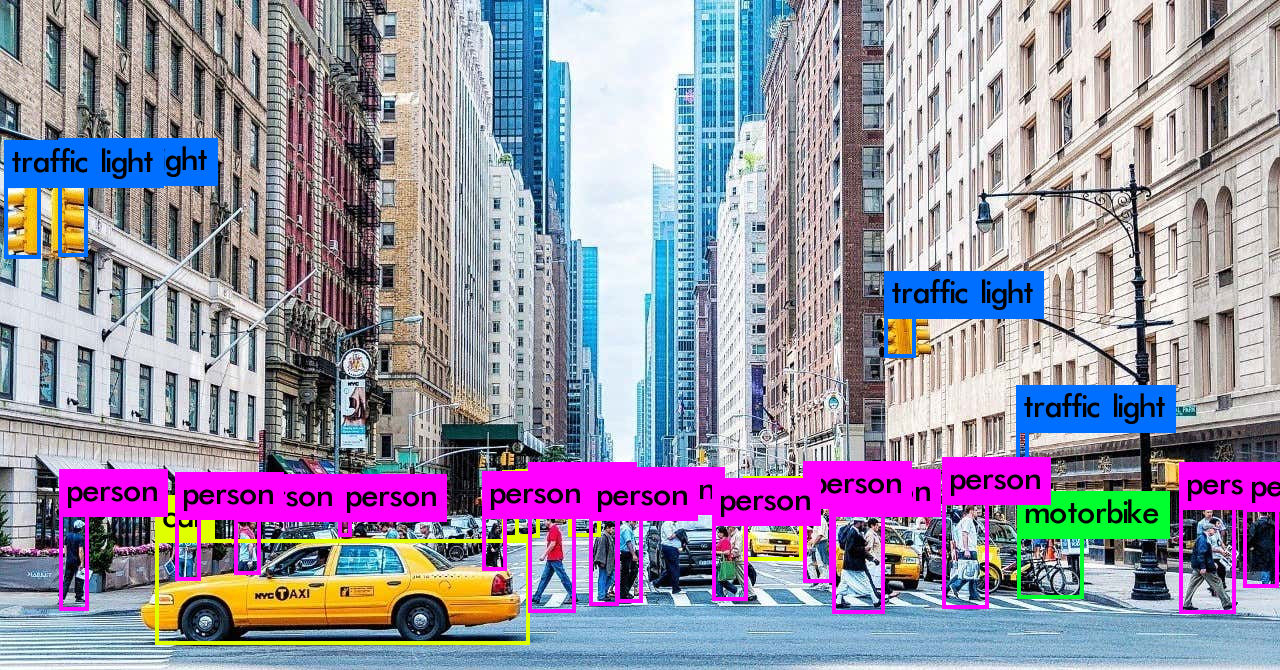

In [11]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('darknet/predictions.jpg'))